In [1]:
import libraries as lib
import geopandas as gpd
import pandas as pd
import rasterio as rio
import xarray as xr
import rioxarray
!pip install openpyxl
import openpyxl

In [2]:
import os
from shapely.geometry import box
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import xrspatial.multispectral as ms
from xrspatial.focal import mean, focal_stats, hotspots
import stackstac
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import OrderedDict
from shapely.geometry import shape
import rioxarray
from rasterio.crs import CRS
from rasterio.plot import show
import rasterio.features
import itertools
import cartopy.crs as ccrs
import rioxarray
import dask.array as da
import joblib
import xarray as xr
from geopandas import GeoDataFrame
from pandas import Series
from xarray import Dataset
from flox.xarray import xarray_reduce
import warnings

In [3]:
GFW = xr.open_dataset("LossYear_GFW_Fiji.tif")
print(GFW.rio.crs)

EPSG:4326


In [4]:
Yasa_34kn = gpd.read_file("Yasa_34n_val.geojson").fillna(0)
Yasa_50kn = gpd.read_file("Yasa_50n_val.geojson").fillna(0)
Yasa_64kn = gpd.read_file("Yasa_64n_val.geojson").fillna(0)

In [5]:
print(Yasa_34kn.crs)
print(Yasa_50kn.crs)
print(Yasa_64kn.crs)

EPSG:4326
EPSG:4326
EPSG:4326


In [6]:
Yasa_34kn = Yasa_34kn.to_crs("EPSG:4326")
Yasa_50kn = Yasa_50kn.to_crs("EPSG:4326")
Yasa_64kn = Yasa_64kn.to_crs("EPSG:4326")

In [7]:
GFW_Yasa_34kn = GFW.rio.clip(Yasa_34kn.geometry, Yasa_34kn.crs)
GFW_Yasa_50kn = GFW.rio.clip(Yasa_50kn.geometry, Yasa_50kn.crs)
GFW_Yasa_64kn = GFW.rio.clip(Yasa_64kn.geometry, Yasa_64kn.crs)

In [8]:
# GFW_Yasa_34kn.head()

In [9]:
GFW.head()

<xarray.Dataset> Size: 196B
Dimensions:      (band: 1, x: 5, y: 5)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 40B 176.8 176.8 176.8 176.8 176.8
  * y            (y) float64 40B -15.96 -15.96 -15.96 -15.96 -15.96
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 100B ...

In [10]:
tif_file = ("LossYear_GFW_Fiji.tif")

In [11]:
# Sachin's stats function
def get_stats(tif_file):
    da = rioxarray.open_rasterio(tif_file,
    default_name="year",
    chunks =True,
    ).squeeze()
    
    years = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
    summary = xarray_reduce(da, da, func="count", expected_groups=years)
    summary = summary.to_pandas()
    summary = summary.to_frame()
    df = summary
    df.rename(columns={0: "pixel_count"}, inplace=True)
    total = df.sum().to_numpy()[0]
    df["percent"] = (df["pixel_count"] / total) * 100
    df["class"] = ""
    df.loc[df.index == 1, "class"] = "2001"
    df.loc[df.index == 2, "class"] = "2002"
    df.loc[df.index == 3, "class"] = "2003"
    df.loc[df.index == 4, "class"] = "2004"
    df.loc[df.index == 5, "class"] = "2005"
    df.loc[df.index == 6, "class"] = "2006"
    df.loc[df.index == 7, "class"] = "2007"
    df.loc[df.index == 8, "class"] = "2008"
    df.loc[df.index == 9, "class"] = "2009"
    df.loc[df.index == 10, "class"] = "2010"
    df.loc[df.index == 11, "class"] = "2011"
    df.loc[df.index == 12, "class"] = "2012"
    df.loc[df.index == 13, "class"] = "2013"
    df.loc[df.index == 14, "class"] = "2014"
    df.loc[df.index == 15, "class"] = "2015"
    df.loc[df.index == 16, "class"] = "2016"
    df.loc[df.index == 17, "class"] = "2017"
    df.loc[df.index == 18, "class"] = "2018"
    df.loc[df.index == 19, "class"] = "2019"
    df.loc[df.index == 20, "class"] = "2020"
    df.loc[df.index == 21, "class"] = "2021"
    df.loc[df.index == 22, "class"] = "2022"
    df.loc[df.index == 23, "class"] = "2023"
    df = df[["class", "pixel_count", "percent"]]
    return df

In [12]:
GFW_totals = get_stats(tif_file)
GFW_totals

,class,pixel_count,percent
year,,,
1,2001,13075,1.937014
2,2002,8292,1.228430
3,2003,18534,2.745745
4,2004,24734,3.664253
5,2005,19622,2.906929
6,2006,22065,3.268850
7,2007,25271,3.743807
8,2008,28088,4.161136
9,2009,21028,3.115222


In [13]:
sum_total = GFW_totals['percent'].sum()
sum_total

100.00000000000004

In [14]:
def get_stats_2(dataset):
    # Ensure input is an xarray.DataArray
    if isinstance(dataset, xr.Dataset):
        # Select the first data variable (or choose a specific one by name)
        da = dataset.to_array().squeeze()
    elif isinstance(dataset, xr.DataArray):
        da = dataset
    else:
        raise TypeError("Input must be an xarray Dataset or DataArray")
    
    # Assign a name to the DataArray if it's unnamed
    if da.name is None:
        da.name = "data_variable"

    # Example year list
    years = list(range(1, 24))

    # Assuming xarray_reduce is correctly defined for DataArray
    summary = xarray_reduce(da, da, func="count", expected_groups=years)

    return summary

# Example usage
# GFW_Yasa_34kn should be an already loaded xarray.Dataset or xarray.DataArray
# stats_2 = get_stats_2(GFW_Yasa_34kn)
# print(stats_2)


In [15]:
stats_GFW_Yasa_34kn = get_stats_2(GFW_Yasa_34kn)
stats_GFW_Yasa_50kn = get_stats_2(GFW_Yasa_50kn)
stats_GFW_Yasa_64kn = get_stats_2(GFW_Yasa_64kn)

In [16]:
# # Plot a specific variable
# GFW_Yasa_34kn['band_data'].plot(robust=True, cmap='viridis')

# # Show the plot
# plt.show()

In [54]:
# # Assuming GFW_Winston_34kn is an xarray Dataset or DataArray
# lon_min = GFW_Yasa_34kn['x'].min().item()
# lon_max = GFW_Yasa_34kn['x'].max().item()
# lat_min = GFW_Yasa_34kn['y'].min().item()
# lat_max = GFW_Yasa_34kn['y'].max().item()

# extent = [lon_min, lon_max, lat_min, lat_max]
# print("Extent of xarray Data:", extent)


In [55]:
# bbox = [176.788597548992, 181.8642585673241, -19.37141215048045, -15.959341206809269]
# bbox_polygon = box(*bbox)

In [56]:
bbox = gpd.read_file("bbox_fiji.geojson")
bbox

,id,geometry
0,None,"MULTIPOLYGON (((177.08975 -19.29811, 177.08975..."


In [20]:
print(bbox.keys())  # This will show the top-level keys
print(bbox)  # This will display the entire structure

Index(['id', 'geometry'], dtype='object')
     id                                           geometry
0  None  MULTIPOLYGON (((177.08975 -19.29811, 177.08975...


In [28]:
# Assuming bbox is your GeoDataFrame with the bounding box geometry
bbox_geometry = bbox['geometry']

# Perform the clipping
GFW_Yasa_34kn = GFW.rio.clip(bbox_geometry, Yasa_34kn.crs)
GFW_Yasa_50kn = GFW.rio.clip(bbox_geometry, Yasa_50kn.crs)
GFW_Yasa_64kn = GFW.rio.clip(bbox_geometry, Yasa_64kn.crs)

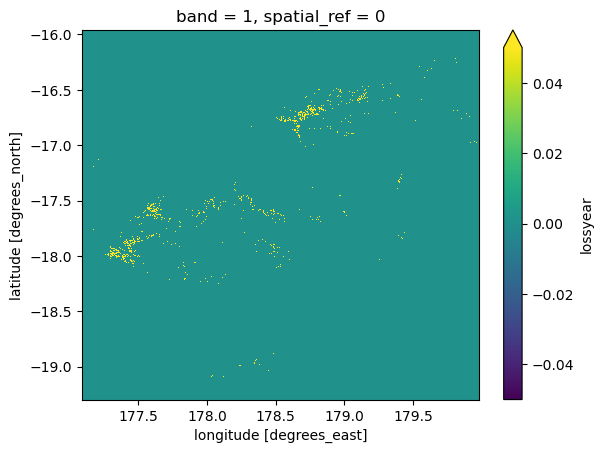

In [27]:
# Plot a specific variable
GFW_Yasa_34kn['band_data'].plot(robust=True, cmap='viridis')

# Show the plot
plt.show()

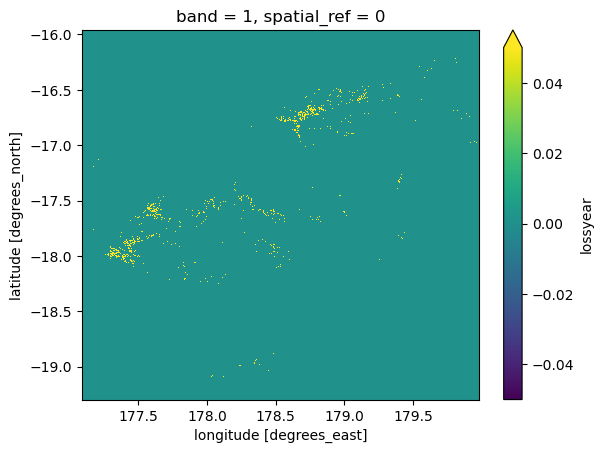

In [29]:
# Plot a specific variable
GFW_Yasa_50kn['band_data'].plot(robust=True, cmap='viridis')

# Show the plot
plt.show()

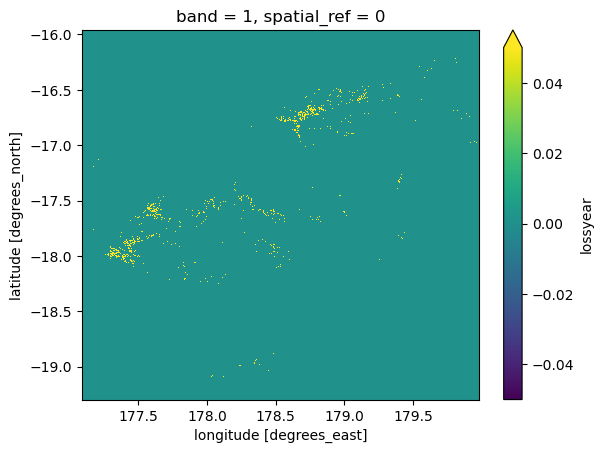

In [30]:
# Plot a specific variable
GFW_Yasa_64kn['band_data'].plot(robust=True, cmap='viridis')

# Show the plot
plt.show()

In [31]:
summary_GFW_Yasa_34kn = stats_GFW_Yasa_34kn.to_pandas()  # Converts to pandas Series
summary_GFW_Yasa_34kn = summary_GFW_Yasa_34kn.to_frame(name="34 knots")  # Converts Series to DataFrame
print(summary_GFW_Yasa_34kn)

               34 knots
data_variable          
1                 12802
2                  8227
3                 18371
4                 24622
5                 19575
6                 21914
7                 25202
8                 27958
9                 20825
10                27416
11                 6450
12                15144
13                34726
14                49276
15                24838
16               112955
17                40890
18                12722
19                19509
20                23553
21                91606
22                13090
23                11213


In [32]:
summary_GFW_Yasa_50kn = stats_GFW_Yasa_50kn.to_pandas()  # Converts to pandas Series
summary_GFW_Yasa_50kn = summary_GFW_Yasa_50kn.to_frame(name="50 knots")  # Converts Series to DataFrame
print(summary_GFW_Yasa_50kn)

               50 knots
data_variable          
1                  1778
2                  1142
3                  2586
4                  4282
5                  3984
6                  2773
7                  2257
8                  4998
9                  3879
10                 7152
11                 1628
12                 3233
13                14130
14                27098
15                14566
16                33000
17                25809
18                 4110
19                10410
20                12821
21                76726
22                 7875
23                 6671


In [33]:
summary_GFW_Yasa_64kn = stats_GFW_Yasa_64kn.to_pandas()  # Converts to pandas Series
summary_GFW_Yasa_64kn = summary_GFW_Yasa_64kn.to_frame(name="64 knots")  # Converts Series to DataFrame
print(summary_GFW_Yasa_64kn)

               64 knots
data_variable          
1                  1713
2                  1095
3                  2448
4                  3911
5                  3871
6                  2606
7                  2118
8                  4850
9                  3692
10                 6939
11                 1500
12                 3056
13                14069
14                26672
15                12308
16                25229
17                25809
18                 3887
19                10410
20                12684
21                76726
22                 7875
23                 6641


In [34]:
GFW_Fiji_km2 = pd.read_csv("Tree_cover_loss_km2_FJ.csv")
GFW_Fiji_km2

,Year,km_2
0,2001,10.97
1,2002,7.03
2,2003,15.73
3,2004,20.79
4,2005,16.66
5,2006,18.75
6,2007,21.49
7,2008,23.87
8,2009,17.90
9,2010,23.46


In [35]:
df_horizontal = pd.concat([summary_GFW_Yasa_34kn, summary_GFW_Yasa_50kn, summary_GFW_Yasa_64kn, GFW_totals['pixel_count']], axis=1)

In [36]:
join_column = GFW_Fiji_km2['Year']
df1 = df_horizontal.merge(GFW_Fiji_km2[['Year', 'km_2']], on=join_column, how='left')
df1

,key_0,34 knots,50 knots,64 knots,pixel_count,Year,km_2
0,2001,12802,1778,1713,13075,2001,10.97
1,2002,8227,1142,1095,8292,2002,7.03
2,2003,18371,2586,2448,18534,2003,15.73
3,2004,24622,4282,3911,24734,2004,20.79
4,2005,19575,3984,3871,19622,2005,16.66
5,2006,21914,2773,2606,22065,2006,18.75
6,2007,25202,2257,2118,25271,2007,21.49
7,2008,27958,4998,4850,28088,2008,23.87
8,2009,20825,3879,3692,21028,2009,17.90
9,2010,27416,7152,6939,27644,2010,23.46


In [37]:
df = df1
df['34kn_%'] = df['34 knots']/df['pixel_count']*100
df['50kn_%'] = df['50 knots']/df['pixel_count']*100
df['64kn_%'] = df['64 knots']/df['pixel_count']*100
df['km_2'] = GFW_Fiji_km2['km_2']
df

,key_0,34 knots,50 knots,64 knots,pixel_count,Year,km_2,34kn_%,50kn_%,64kn_%
0,2001,12802,1778,1713,13075,2001,10.97,97.912046,13.598470,13.101338
1,2002,8227,1142,1095,8292,2002,7.03,99.216112,13.772311,13.205499
2,2003,18371,2586,2448,18534,2003,15.73,99.120535,13.952736,13.208158
3,2004,24622,4282,3911,24734,2004,20.79,99.547182,17.312202,15.812242
4,2005,19575,3984,3871,19622,2005,16.66,99.760473,20.303741,19.727856
5,2006,21914,2773,2606,22065,2006,18.75,99.315658,12.567414,11.810560
6,2007,25202,2257,2118,25271,2007,21.49,99.726960,8.931186,8.381148
7,2008,27958,4998,4850,28088,2008,23.87,99.537169,17.794076,17.267160
8,2009,20825,3879,3692,21028,2009,17.90,99.034621,18.446833,17.557542
9,2010,27416,7152,6939,27644,2010,23.46,99.175228,25.871799,25.101288


In [38]:
df = df.drop(columns=['Year'])


In [39]:
df = df.rename(columns={'key_0':'Year'})
df

,Year,34 knots,50 knots,64 knots,pixel_count,km_2,34kn_%,50kn_%,64kn_%
0,2001,12802,1778,1713,13075,10.97,97.912046,13.598470,13.101338
1,2002,8227,1142,1095,8292,7.03,99.216112,13.772311,13.205499
2,2003,18371,2586,2448,18534,15.73,99.120535,13.952736,13.208158
3,2004,24622,4282,3911,24734,20.79,99.547182,17.312202,15.812242
4,2005,19575,3984,3871,19622,16.66,99.760473,20.303741,19.727856
5,2006,21914,2773,2606,22065,18.75,99.315658,12.567414,11.810560
6,2007,25202,2257,2118,25271,21.49,99.726960,8.931186,8.381148
7,2008,27958,4998,4850,28088,23.87,99.537169,17.794076,17.267160
8,2009,20825,3879,3692,21028,17.90,99.034621,18.446833,17.557542
9,2010,27416,7152,6939,27644,23.46,99.175228,25.871799,25.101288


In [40]:
df.set_index('Year', inplace=True)



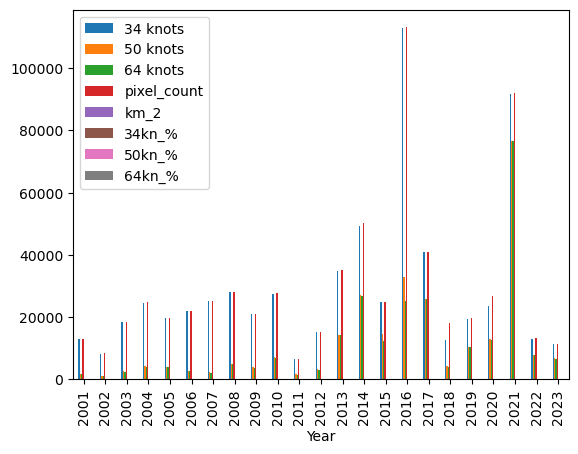

In [41]:
# Plot a bar chart
df.plot(kind='bar', legend=True)

# Display the plot
import matplotlib.pyplot as plt
plt.show()

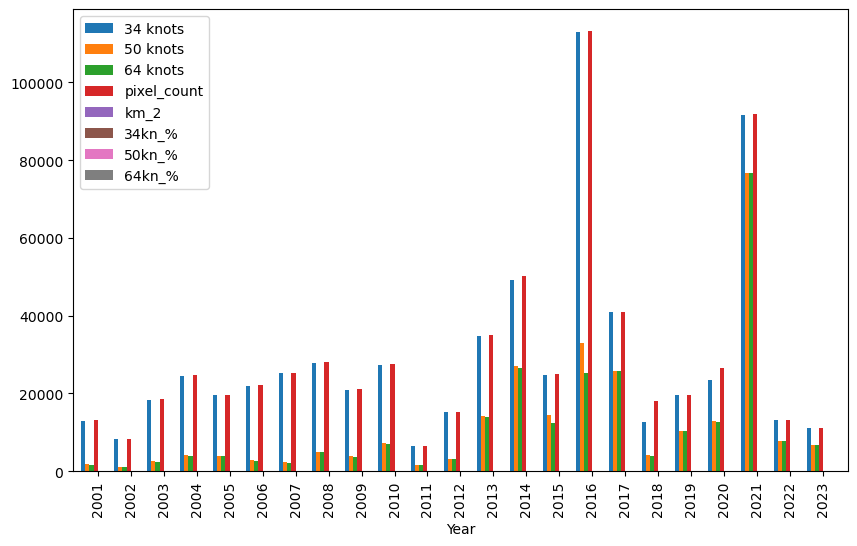

In [42]:
ax = df.plot(kind='bar', figsize=(10, 6), width=1, legend=True)

In [43]:
df.to_excel("Yasa_2021_swaths_GFW.xlsx")

In [44]:
yasa_df = df.iloc[[20]]
yasa_df


,34 knots,50 knots,64 knots,pixel_count,km_2,34kn_%,50kn_%,64kn_%
Year,,,,,,,,
2021,91606,76726,76726,91974,71.99,99.599887,83.421402,83.421402


In [45]:
yasa_df["34 knots km2"] = yasa_df["km_2"]*((yasa_df["34kn_%"])/100)
yasa_df["50 knots km2"] = yasa_df["km_2"]*((yasa_df["50kn_%"])/100)
yasa_df["64 knots km2"] = yasa_df["km_2"]*((yasa_df["64kn_%"])/100)
yasa_df

,34 knots,50 knots,64 knots,pixel_count,km_2,34kn_%,50kn_%,64kn_%,34 knots km2,50 knots km2,64 knots km2
Year,,,,,,,,,,,
2021,91606,76726,76726,91974,71.99,99.599887,83.421402,83.421402,71.701959,60.055067,60.055067


In [46]:
yasa_df

,34 knots,50 knots,64 knots,pixel_count,km_2,34kn_%,50kn_%,64kn_%,34 knots km2,50 knots km2,64 knots km2
Year,,,,,,,,,,,
2021,91606,76726,76726,91974,71.99,99.599887,83.421402,83.421402,71.701959,60.055067,60.055067


In [47]:
yasa_df["64kn swath km2"] = yasa_df["64 knots km2"]
yasa_df["50kn swath km2"] = yasa_df["50 knots km2"] - yasa_df["64 knots km2"]
yasa_df["34kn swath km2"] = yasa_df["34 knots km2"] - yasa_df["50 knots km2"]
yasa_df["national tree cover loss km2"] = yasa_df["km_2"] - yasa_df["34 knots km2"]
yasa_df["national tree cover loss km2"] = yasa_df["km_2"] - yasa_df["34 knots km2"]
yasa_df


,34 knots,50 knots,64 knots,pixel_count,km_2,34kn_%,50kn_%,64kn_%,34 knots km2,50 knots km2,64 knots km2,64kn swath km2,50kn swath km2,34kn swath km2,national tree cover loss km2
Year,,,,,,,,,,,,,,,
2021,91606,76726,76726,91974,71.99,99.599887,83.421402,83.421402,71.701959,60.055067,60.055067,60.055067,0.0,11.646892,0.288041


In [48]:
yasa_df = yasa_df.drop(columns=['km_2', '34 knots', '50 knots', '64 knots', 'pixel_count', '34 knots km2', '50 knots km2', '64 knots km2','34kn_%', '50kn_%', '64kn_%'])
yasa_df

,64kn swath km2,50kn swath km2,34kn swath km2,national tree cover loss km2
Year,,,,
2021,60.055067,0.0,11.646892,0.288041


In [49]:
col_order = ['64 knots', '50 knots', '34 knots', 'pixel count']

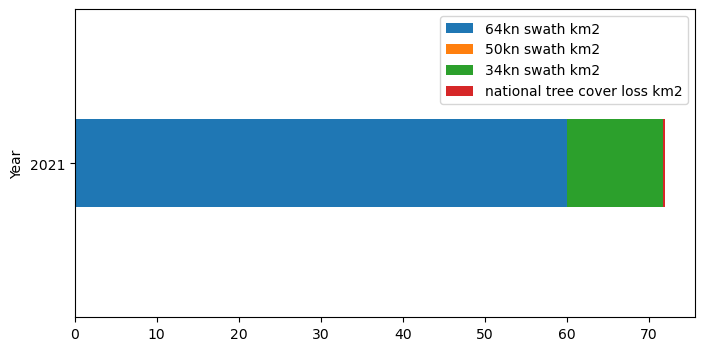

In [50]:
ax_yasa = yasa_df.plot(kind='barh', stacked=True, figsize=(8, 4), width=0.2, legend=True)

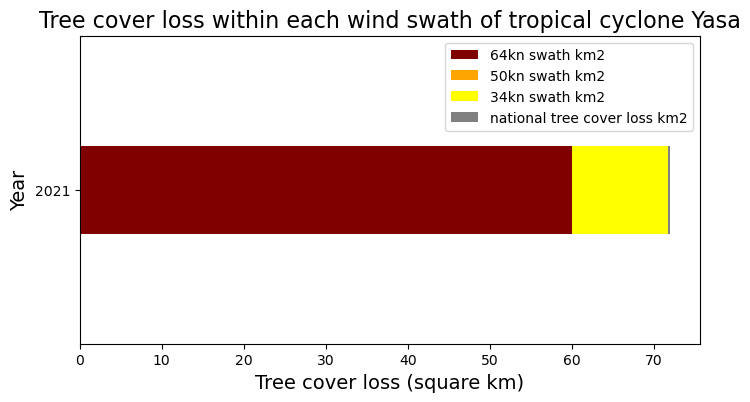

In [51]:
# List of colors for each bar
colors = ['maroon', 'orange', 'yellow', 'grey']

# Plot the bar chart with specific colors for each bar
ax = yasa_df.plot(kind='barh', color=colors, stacked=True, width=0.2, figsize=(8, 4), legend=True)

# Set title and labels
ax.set_title('Tree cover loss within each wind swath of tropical cyclone Yasa', fontsize=16)
ax.set_xlabel('Tree cover loss (square km)', fontsize=14)
ax.set_ylabel('Year', fontsize=14)

# Display the plot
plt.show()